In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torch.optim import lr_scheduler
from torch.utils.data import  DataLoader,datasets,Subset
from torchvision import datasets, models, transforms
from PIL import Image
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
import torchvision.models as models
import copy

from tqdm import tqdm,trange
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchmetrics import Accuracy


from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, f1_score


In [2]:
process_images = False
generate_datasets = False
generate_datasets_test = False

In [3]:
# model = models.resnet152(pretrained = True)
model = models.resnet152(pretrained = True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
# sample execution (requires torchvision)
if process_images == True:

    for filename in tqdm(os.listdir("./task4_be9ai3nsdj/food/food/"), desc="Processing images..."):
    #     print(filename)
        if filename.endswith(".jpg"):

            input_image = Image.open("./task4_be9ai3nsdj/food/food/{}".format(filename))
            preprocess = transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            input_tensor = preprocess(input_image)
            input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
            if torch.cuda.is_available():
                input_batch = input_batch.to('cuda')
                model.to('cuda')
            output = model(input_batch)
            # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    #         print(output[0])
            # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
            output_np = output.cpu().detach().numpy()
            np.save(
            "processed_images/" + filename[:-4] + ".npy", output_np
            )

else:
    pass



In [5]:
if generate_datasets == True:

    idx = np.loadtxt("./task4_be9ai3nsdj/train_triplets.txt", dtype=str)

    images_1 = [None] * idx.shape[0]
    images_2 = [None] * idx.shape[0]
    images_3 = [None] * idx.shape[0]

    for i in tqdm(range(idx.shape[0])):
        row = idx[i, :]
        images_1[i] = np.load("processed_images/{}.npy".format(row[0]))
        images_2[i] = np.load("processed_images/{}.npy".format(row[1]))
        images_3[i] = np.load("processed_images/{}.npy".format(row[2]))

    A = np.vstack(images_1)
    B = np.vstack(images_2)
    C = np.vstack(images_3)

    X1 = np.vstack((A, A, B))
    X2 = np.vstack((B, C, A))
    X3 = np.vstack((C, B, C))

    np.save("X1_InceptionV3.npy", X1)
    np.save("X2_InceptionV3.npy", X2)
    np.save("X3_InceptionV3.npy", X3)

X1 = np.load("X1_InceptionV3.npy").astype(np.float32)
X2 = np.load("X2_InceptionV3.npy").astype(np.float32)
X3 = np.load("X3_InceptionV3.npy").astype(np.float32)

dsize = X1.shape[0]
y_shape = (int(dsize / 3), 1)

Y = np.vstack((np.ones(y_shape), np.zeros(y_shape), np.ones(y_shape))).astype(np.float32)
print(X1.shape)
if X1 is not None:
    # If to ensure this cell isn't run twice.
    (
        X1_train,
        X1_validate,
        X2_train,
        X2_validate,
        X3_train,
        X3_validate,
        Y_train,
        Y_validate,
    ) = train_test_split(X1, X2, X3, Y, test_size=0.10, random_state=0, shuffle=True)

    # And freeing some memory
    del X1
    X1 = None
    del X2
    X2 = None
    del X3
    X3 = None

(178545, 1000)


In [6]:
# if generate_datasets == True:

#     idx = np.loadtxt("./task4_be9ai3nsdj/train_triplets.txt", dtype=str)

#     images_1 = [None] * idx.shape[0]
#     images_2 = [None] * idx.shape[0]
#     images_3 = [None] * idx.shape[0]

#     for i in tqdm(range(idx.shape[0])):
#         row = idx[i, :]
#         images_1[i] = np.load("processed_images/{}.npy".format(row[0]))
#         images_2[i] = np.load("processed_images/{}.npy".format(row[1]))
#         images_3[i] = np.load("processed_images/{}.npy".format(row[2]))

#     A = np.vstack(images_1)
#     B = np.vstack(images_2)
#     C = np.vstack(images_3)

#     X1 = np.vstack((A, A))
#     X2 = np.vstack((B, C))
#     X3 = np.vstack((C, B))

#     np.save("X1_InceptionV3_no3rdass.npy", X1)
#     np.save("X2_InceptionV3_no3rdass.npy", X2)
#     np.save("X3_InceptionV3_no3rdass.npy", X3)

# X1 = np.load("X1_InceptionV3_no3rdass.npy").astype(np.float32)
# X2 = np.load("X2_InceptionV3_no3rdass.npy").astype(np.float32)
# X3 = np.load("X3_InceptionV3_no3rdass.npy").astype(np.float32)

# dsize = X1.shape[0]
# y_shape = (int(dsize / 2), 1)

# Y = np.vstack((np.ones(y_shape), np.zeros(y_shape))).astype(np.float32)

# if X1 is not None:
#     # If to ensure this cell isn't run twice.
#     (
#         X1_train,
#         X1_validate,
#         X2_train,
#         X2_validate,
#         X3_train,
#         X3_validate,
#         Y_train,
#         Y_validate,
#     ) = train_test_split(X1, X2,X3, Y, test_size=0.10, random_state=0, shuffle=True)

#     # And freeing some memory
#     del X1
#     X1 = None
#     del X2
#     X2 = None
#     del X3
#     X3 = None

In [7]:
if generate_datasets_test == True:

    idx = np.loadtxt("./task4_be9ai3nsdj/test_triplets.txt", dtype=str)

    images_1 = [None] * idx.shape[0]
    images_2 = [None] * idx.shape[0]
    images_3 = [None] * idx.shape[0]

    for i in tqdm(range(idx.shape[0])):
        row = idx[i, :]
        images_1[i] = np.load(f"processed_images/{row[0]}.npy")
        images_2[i] = np.load(f"processed_images/{row[1]}.npy")
        images_3[i] = np.load(f"processed_images/{row[2]}.npy")

    X1_test = np.vstack(images_1)
    X2_test = np.vstack(images_2)
    X3_test = np.vstack(images_3)

    np.save("X1_test_InceptionV3.npy", X1_test)
    np.save("X2_test_InceptionV3.npy", X2_test)
    np.save("X3_test_InceptionV3.npy", X3_test)


X1_test = np.load("X1_test_InceptionV3.npy").astype(np.float32)
X2_test = np.load("X2_test_InceptionV3.npy").astype(np.float32)
X3_test = np.load("X3_test_InceptionV3.npy").astype(np.float32)

In [8]:
if not "scaler" in locals():
    scaler = StandardScaler()

    X1_train, X2_train, X3_train = np.vsplit(
        scaler.fit_transform(np.vstack((X1_train, X2_train, X3_train))), 3
    )

    # Transform the training data
    X1_validate = scaler.transform(X1_validate)
    X2_validate = scaler.transform(X2_validate)
    X3_validate = scaler.transform(X3_validate)

    # Transform the testing data
    X1_test = scaler.transform(X1_test)
    X2_test = scaler.transform(X2_test)
    X3_test = scaler.transform(X3_test)




In [9]:
device = torch.device("cuda")
batch = 50

In [10]:
X1_train_tensor=torch.tensor(X1_train).to(device)
X2_train_tensor=torch.tensor(X2_train).to(device)
X3_train_tensor=torch.tensor(X3_train).to(device)
Y_train_tensor = torch.tensor(Y_train).to(device)
train_dataset = torch.utils.data.TensorDataset(X1_train_tensor,X2_train_tensor,X3_train_tensor,
                                            Y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch)

X1_validate_tensor=torch.tensor(X1_validate).to(device)
X2_validate_tensor=torch.tensor(X2_validate).to(device)
X3_validate_tensor=torch.tensor(X3_validate).to(device)
Y_validate_tensor = torch.tensor(Y_validate).to(device)
validate_dataset = torch.utils.data.TensorDataset(X1_validate_tensor,X2_validate_tensor,X3_validate_tensor,
                                            Y_validate_tensor)
validate_dataloader = torch.utils.data.DataLoader(validate_dataset,batch_size=batch)

X1_test_tensor=torch.tensor(X1_test).to(device)
X2_test_tensor=torch.tensor(X2_test).to(device)
X3_test_tensor=torch.tensor(X3_test).to(device)
test_dataset = torch.utils.data.TensorDataset(X1_test_tensor,X2_test_tensor,X3_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch)

In [11]:
class Densenet(torch.nn.Module):

    def __init__(self, input_layer,out_features,seed = 10):
        self.PW = 2000
        self.DW = 500
        super().__init__()
        self.parelleblock= nn.Sequential(nn.Sequential(nn.Linear(in_dim, self.PW),nn.ReLU()),
#                            nn.Sequential(nn.Linear(self.PW, 1500),nn.ReLU()),
#                             nn.Sequential(nn.Dropout(p=0.7)),
                           nn.Sequential(nn.Linear(self.PW, 500,bias=False),nn.ReLU()),
                           nn.Sequential(nn.Linear(500, 300,bias=False),nn.ReLU()),
                           nn.Sequential(nn.Linear(300, 300,bias=False),nn.ReLU()),
                           nn.Sequential(nn.Dropout(p=0.5)),
                           nn.Sequential(nn.Linear(300, 300,bias=False),nn.ReLU()),
                           nn.Sequential(nn.Linear(300, 300,bias=False),nn.ReLU()),
                           nn.Sequential(nn.Linear(300, 300,bias=False),nn.ReLU()),
#                            nn.Sequential(nn.Dropout(p=0.2)),
                           nn.Sequential(nn.Linear(300, 200,bias=False),nn.ReLU()))
        
        
        self.DB=nn.Sequential(nn.Sequential(nn.Linear(200*3, 72,bias=False ),nn.ReLU()),
                   nn.Sequential(nn.Linear(72, 18,bias=False),nn.ReLU()),
                nn.Sequential(nn.Linear(18 , 1 ),nn.Sigmoid())
#                    nn.Sequential(nn.Linear(200 , 1 ),nn.ReLU())
                              )
        # self.net.to(device)
    def forward(self, im1,im2,im3):
        u1= self.parelleblock(im1)
        u2 = self.parelleblock(im2)
        u3 = self.parelleblock(im3)
#         print(u1.shape,u2.shape,u3.shape)
        cat = torch.cat((u1, u2,u3), dim=1) #keep track of dims
#         print(cat.shape)
        out = self.DB(cat).to(device)
        return out
    def predict(self, im1,im2,im3):
         return (self.forward(im1,im2,im3))
#         return nn.functional.softmax(self.forward(im1,im2,im3),dim=0)
# def forward(self, image, data):
#         x1 = self.cnn(image)
#         x2 = data
        
#         x = torch.cat((x1, x2), dim=1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

In [12]:
in_dim = X1_train.shape[1]
print(in_dim)
out_dim = Y_train.shape[1]
net_instance = Densenet(in_dim,out_dim).to(device)
# net_instance.to(device)

1000


In [13]:
# net_instance.to(device)
# for batch_x1,batch_x2,batch_x3,batch_y in train_dataloader:
#     net_instance.forward(batch_x1,batch_x2,batch_x3)


In [14]:
optimizer = optim.AdamW(net_instance.parameters(), lr=1e-4,weight_decay  =1e-2,amsgrad =False )
loss_function = nn.BCELoss()
# scheduler = lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)
accuracy = Accuracy().to(device)

In [15]:
# Run the training loop for defined number of epochs
def train_network(
    model,
    optimizer,
    training_data_loader,
    testing_data_loader,
    training_loss_fn,
    testing_loss_fn,
    num_epochs,
):
    pbar = trange(num_epochs)

    training_losses = []
    testing_losses = []
    testing_accuracy = []
    for i in pbar:

        training_losses_batch = []
        for batch_x1,batch_x2,batch_x3,batch_y in training_data_loader:
            model.zero_grad()
#             optimizer.zero_grad()
            y_pred = model(batch_x1,batch_x2,batch_x3)
            loss = training_loss_fn(y_pred, batch_y)
            training_losses_batch.append(loss)
            y_int = batch_y.type(torch.int).to(device)
            ypred_accur = accuracy(y_pred,y_int)
            pbar.set_description("loss {:.3f} accuracy{:.3f} LR{}:".format(loss,ypred_accur,optimizer.param_groups[0]['lr']))
            loss.backward()
            optimizer.step()
            
        training_losses.append(
            torch.mean(torch.stack(training_losses_batch)).detach()
        )
#         scheduler.step()
        testing_losses_batch = []
        testing_accuracy_batch = []
        for test_x1, test_x2,test_x3,test_y in testing_data_loader:
            y_pred_test = model( test_x1, test_x2,test_x3)
            testing_losses_batch.append(testing_loss_fn(y_pred_test, test_y))
            y_testint = test_y.type(torch.int).to(device)
            testing_accuracy_batch.append(accuracy(y_pred_test,y_testint))
        
        testing_accuracy.append(
            torch.mean(torch.stack(testing_accuracy_batch)).detach()
        )
        testing_losses.append(
            torch.mean(torch.stack(testing_losses_batch)).detach()
        )

    return (
        torch.stack(training_losses).detach().cpu().numpy(),
        torch.stack(testing_losses).detach().cpu().numpy(),
        torch.stack(testing_accuracy).detach().cpu().numpy(),
    )


In [16]:
training_losses, testing_losses,testing_accuracy = train_network(net_instance,optimizer,train_dataloader,
                                                validate_dataloader,loss_function,
                                                loss_function,20)

loss 0.250 accuracy0.900 LR0.0001:: 100%|██████████████████████████████████████████████| 20/20 [13:02<00:00, 39.11s/it]


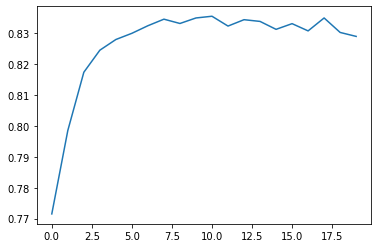

In [17]:
plt.plot(testing_accuracy)

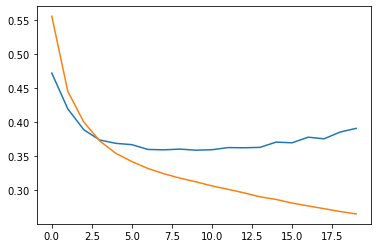

In [18]:
import matplotlib.pyplot as plt 
plt.plot(testing_losses)
plt.plot(training_losses)

In [19]:
prediction = []
for batch_x1,batch_x2,batch_x3 in test_dataloader:
    prediction_temp = net_instance.predict(batch_x1,batch_x2,batch_x3)
    prediction_temp = prediction_temp.cpu().detach().numpy()
    prediction = np.append(prediction,prediction_temp)

prediction_rounded = np.round(prediction)

In [ ]:
prediction_rounded

In [55]:
pd.DataFrame(prediction_rounded.T).to_csv('prediction_network_Two.csv', index=False, header=None)

In [56]:
reference = np.loadtxt('Best_score.csv')

In [57]:
reference=torch.tensor(reference)
reference = reference.to(torch.int)
prediction_rounded=torch.tensor( prediction_rounded)
prediction_rounded = prediction_rounded.to(torch.int)

In [58]:
accu_ref = Accuracy()
accu_ref(prediction_rounded,reference)

tensor(0.7206)